In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.neighbors import KernelDensity

In [3]:
df = pd.read_csv("/content/data.csv", encoding="latin1")
df.head()

/tmp/ipython-input-1360083399.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv", encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [4]:
print(df.columns.tolist())

['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']


In [5]:
vals = df["no2"].dropna().astype(np.float32).to_numpy()
vals = (vals - vals.mean()) / vals.std()

In [6]:
ROLL_NUMBER = 102316066

alpha = 0.5 * (ROLL_NUMBER % 7)
beta = 0.3 * ((ROLL_NUMBER % 5) + 1)

print("Roll Number:", ROLL_NUMBER)
print("Computed Transformation Parameters:")
print("a_r =", alpha)
print("b_r =", beta)

Roll Number: 102316066
Computed Transformation Parameters:
a_r = 3.0
b_r = 0.6


In [7]:
z_vals = vals + alpha * np.sin(beta * vals)
z_vals = z_vals.reshape(-1, 1)

print("Transformation applied: z = x + a_r * sin(b_r * x)")
print("Shape of transformed data z:", z_vals.shape)

z_tensor = torch.tensor(z_vals)

Transformation applied: z = x + a_r * sin(b_r * x)
Shape of transformed data z: (419509, 1)


In [8]:
latent_dim = 1

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
gen = Generator()
disc = Discriminator()

In [13]:
criterion = nn.BCELoss()

opt_g = optim.Adam(gen.parameters(), lr=0.001)
opt_d = optim.Adam(disc.parameters(), lr=0.001)

epochs = 3000
batch_size = 128

In [14]:
for step in range(epochs):

    sample_idx = np.random.randint(0, len(z_vals), batch_size)
    real_data = z_tensor[sample_idx]

    y_real = torch.ones(batch_size, 1)
    y_fake = torch.zeros(batch_size, 1)

    noise_vec = torch.randn(batch_size, latent_dim)
    fake_data = gen(noise_vec)

    loss_real = criterion(disc(real_data), y_real)
    loss_fake = criterion(disc(fake_data.detach()), y_fake)
    d_loss = loss_real + loss_fake

    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    noise_vec = torch.randn(batch_size, latent_dim)
    gen_data = gen(noise_vec)
    g_loss = criterion(disc(gen_data), y_real)

    opt_g.zero_grad()
    g_loss.backward()
    opt_g.step()

    if step % 500 == 0:
        print(f"Epoch {step} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 0 | D Loss: 1.3481 | G Loss: 0.6880
Epoch 500 | D Loss: 1.3951 | G Loss: 0.6899
Epoch 1000 | D Loss: 1.3789 | G Loss: 0.6957
Epoch 1500 | D Loss: 1.3521 | G Loss: 0.7494
Epoch 2000 | D Loss: 1.3765 | G Loss: 0.6917
Epoch 2500 | D Loss: 1.4121 | G Loss: 0.6558


In [15]:
noise = torch.randn(10000, latent_dim)
synth_z = gen(noise).detach().numpy()

In [16]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2)
kde.fit(synth_z)

grid = np.linspace(z_vals.min(), z_vals.max(), 1000).reshape(-1, 1)
log_pdf = kde.score_samples(grid)
pdf = np.exp(log_pdf)

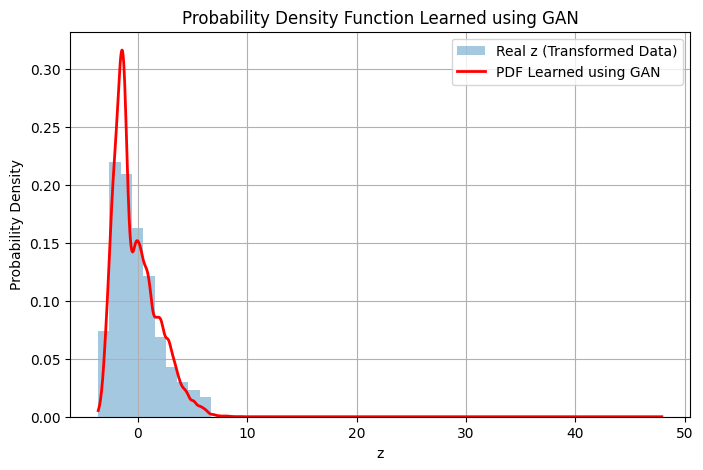

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(z_vals, bins=50, density=True, alpha=0.4, label="Real z (Transformed Data)")
plt.plot(grid, pdf, color="red", linewidth=2, label="PDF Learned using GAN")
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("Probability Density Function Learned using GAN")
plt.legend()
plt.grid(True)
plt.show()

The GAN captures the main patterns of the transformed data, as real and generated samples overlap well. Training remains stable despite expected loss oscillations. The PDF estimated from generated samples closely matches the real data histogram, indicating effective learning of the distribution.